## MNIST example with PyTorch and visualizations

In [0]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# set variables
numClasses = 10
learning_rate = 0.1
n_epochs = 3
root = './data'
batch_size_test = 1000
batch_size_train = 64
momentum = .5
seed = 1
log_interval = 100

In [0]:
# It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting :
# torch.backends.cudnn.enabled = False.

In [75]:
# set our data transform
trans = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,), (1.0,))])

# Load PyTorch's built in MNIST data set and apply the above tranform.
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

# Set up dataloaders which help batch and shuffle data.
train_loader = torch.utils.data.DataLoader( train_set,
  batch_size=batch_size_train, shuffle=True)
print(type(train_loader))

test_loader = torch.utils.data.DataLoader( test_set,
  batch_size=batch_size_test, shuffle=True)


<class 'torch.utils.data.dataloader.DataLoader'>


In [0]:
# Sanity check of dataset sizes and shape
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [104]:
# Print example of from dataset
print(test_loader.dataset[0][0].shape)
print(test_loader.dataset[0][1])

torch.Size([1, 28, 28])
7


In [77]:
print(len(test_loader.dataset)) # 10000
print(len(train_loader.dataset)) # 60000
print(next(examples)[1][0].shape) # check shape of data images

print('One batch of data has the shape: ', example_data.shape)

10000
60000
torch.Size([1000, 1, 28, 28])
One batch of data has the shape:  torch.Size([1000, 1, 28, 28])


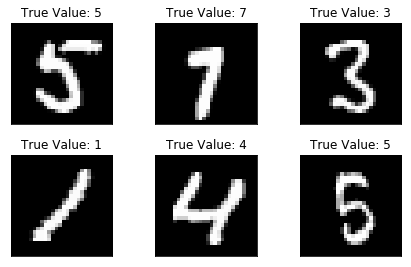

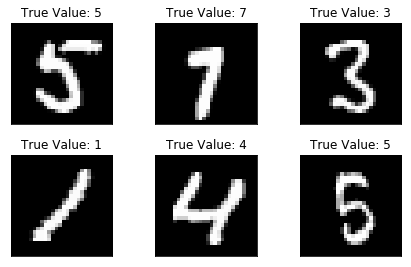

In [78]:
# Display a few MNIST images and their true values with matplotlib
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("True Value: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
# Network 1
class Net_1(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # Convolutional Layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) # Fully Connected Layer
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

# Another Network
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # resizing to be a 1x784 tensor
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net_2()
optimizer = optim.SGD(network.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)

We will use `nll_loss` - negative likelihood
https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.nll_loss

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# Train the network for a given number of epochs
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

# test the network
def test(test_losses):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('In our test set, we should expect around 10% accuracy.')
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return test_losses

Using the context manager no_grad() we can avoid storing the computations done producing the output of our network in the computation graph.

In [83]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [84]:
# Get a baseline by running the network on our test data without training
test_losses = test(test_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In our test set, we should expect around 10% accuracy.

Test set: Avg. loss: 2.3019, Accuracy: 1049/10000 (10%)



In [85]:
# Train the network and run the test again for the number of epochs specified
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test_losses = test(test_losses)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343606


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.396508
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.468591
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.386335
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.457204
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.341786
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.370074
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.358221
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.311048
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.221121


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In our test set, we should expect around 10% accuracy.

Test set: Avg. loss: 0.2159, Accuracy: 9322/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.270828
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.177350
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.176469
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.356457
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.241656
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.119711
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.133939
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.219937
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.263923
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.156814
In our test set, we should expect around 10% accuracy.

Test set: Avg. loss: 0.1496, Accuracy: 9551/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.095384
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.310517
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.390308
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.217708
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.424305
Train Epoch: 3 [32000/60000 (53%)]	L

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


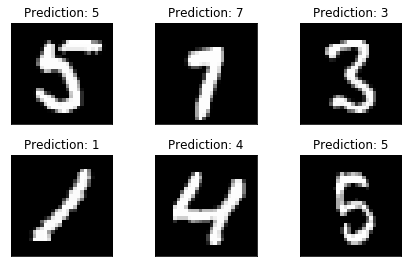

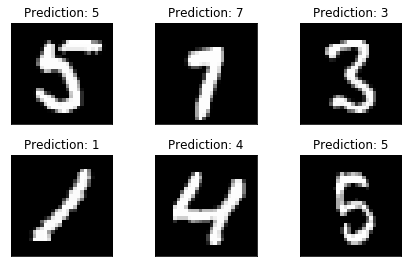

In [87]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [88]:
test(test_losses[:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In our test set, we should expect around 10% accuracy.

Test set: Avg. loss: 0.1285, Accuracy: 9608/10000 (96%)



[2.30194189453125,
 0.21594119873046874,
 0.1496247901916504,
 0.12849817962646484,
 0.12849817123413085]

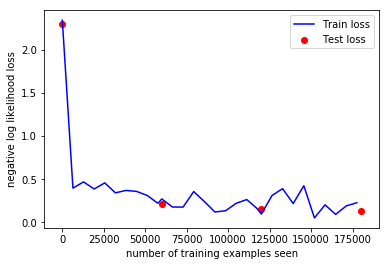

In [89]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

## Continued Training from Checkpoints

In [0]:
continued_network = Net_2()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

Using .load_state_dict() we can now load the internal state of the network and optimizer when we last saved them.

In [0]:
network_state_dict = torch.load('results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

Again running a training loop should immediately pick up the training where we left it. To check on that let's simply use the same lists as before to keep track of the loss values. Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.

In [92]:
for i in range(4, 5):
  test_counter.append(i * len(train_loader.dataset))
  train(i)
  test_losses = test(test_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.136329
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.119865
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.080541
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.383641
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.089956
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.120951
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.146478
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.351907
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.136387
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.090757


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In our test set, we should expect around 10% accuracy.

Test set: Avg. loss: 0.1037, Accuracy: 9686/10000 (96%)



Great! We again see a (much slower) increase in test set accuracy from epoch to epoch. Let's visualize this to further inspect the training progress.

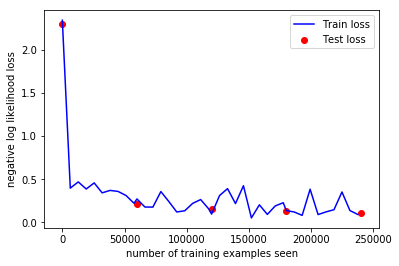

In [94]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()